In [ ]:
# This notebook compares the dopamine signal aligned to movement during the CoT task to the
# dopamine signal evoked by the same high and low frequency sounds played while the mouse is freely moving.

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%cd APE_paper/docs/figures_notebooks
!git checkout YvonneJohansson

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import urllib.request
from os.path import exists
import matplotlib.pylab as plt
import numpy as np
import pickle
from scipy.signal import decimate

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))))
from scripts import YJ_analysis_utils as yj_utils
from scripts import yj_plotting as yj_plot

In [8]:
# # Extended Data 5V & 5W:

# Get dataset information:
dataset_name = 'DataOverview_ED5VW.csv'
dataset_path = '../../data/' + dataset_name

if not exists(dataset_path):
    print('Please download ED_fig5VW from ')
    print('https://figshare.com')
    print('Project: Dopaminergic action prediction errors serve as a value-free teaching signal')
    print('to')
    print(dataset_path)
else:
    print('DataOverview already in directory')

#print(dataset_path)
info = pd.read_csv(dataset_path)

DataOverview already in directory


ParserError: Error tokenizing data. C error: Expected 1 fields in line 10, saw 2


In [1]:
info

NameError: name 'info' is not defined

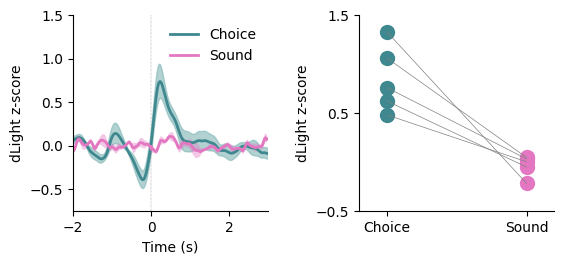

In [6]:
# load mouse data from zenodo and run basic analysis of the CoT session

x_range = [-2, 3]
y_range = [-0.7, 1.5]
nr_mice = len(info['AnimalID'].unique())
for m, mouse in enumerate(info['AnimalID']):
    date = str(info[info['AnimalID']==mouse]['Date'].values[0])
    fiber_side = info[info['AnimalID']==mouse]['fiber_side'].values[0]
    protocol = info[info['AnimalID']==mouse]['protocol1'].values[0]
    dataset_names = []
    # CoT session
    CoT_trial_data = mouse + '_' + date + '_restructured_data.pkl'
    CoT_photo_data = mouse + '_' + date + '_smoothed_signal.npy' 
    # RTC session 
    RTC_trial_data = mouse + '_' + date + '_RTC_restructured_data.pkl'
    RTC_photo_data = mouse + '_' + date + '_RTC_smoothed_signal.npy' 
    dataset_names.extend([CoT_photo_data,CoT_trial_data, RTC_photo_data, RTC_trial_data])


    for i, dataset_name in enumerate(dataset_names):
        url = zenodo + dataset_name
        dataset_path = '../../data/' + dataset_name
        
        if not exists(dataset_path):
            print('Downloading ' + dataset_name)
            urllib.request.urlretrieve(url, dataset_path)
        #else:
        #   print(dataset_name + ' already in directory')
        
        if i == 0:
            photometry_data = np.load(dataset_path)  
            
        if i == 1:  
            trial_data = pd.read_pickle(dataset_path)
            session_traces = yj_utils.SessionData(mouse, date, fiber_side, protocol, trial_data, photometry_data)
            file_name = mouse + '_' + date + '_aligned_traces.p'
            dataset_path = '../../data/' + file_name           
            pickle.dump(session_traces, open(dataset_path, "wb"))
        if i == 2: 
            RTC_photometry_data = np.load(dataset_path)    
            
        if i == 3:
            RTC_trial_data = pd.read_pickle(dataset_path)
            RTC_data = yj_utils.ZScoredTraces_RTC(RTC_trial_data, RTC_photometry_data, x_range)

     
            if session_traces.protocol == 'SOR':
                APE_aligned_data = decimate(session_traces.SOR_choice.contra_data.mean_trace, 10)
                APE_time = decimate(session_traces.SOR_choice.contra_data.time_points, 10)
                APE_sem_traces = decimate(session_traces.SOR_choice.contra_data.sorted_traces,10)
            else:
                APE_aligned_data = decimate(session_traces.choice.contra_data.mean_trace, 10)
                APE_time = decimate(session_traces.choice.contra_data.time_points,10)
                APE_sem_traces = decimate(session_traces.choice.contra_data.sorted_traces,10)
            RTC_aligned_data = decimate(RTC_data.mean_trace, 10)
            RTC_time = decimate(RTC_data.time_points, 10)

            if m == 0:
                APE_traces = np.zeros((nr_mice, len(APE_aligned_data)))
                RTC_traces = np.zeros((nr_mice, len(RTC_aligned_data)))
                APE_sem_traces_upper = np.zeros((nr_mice, len(APE_aligned_data)))
                APE_sem_traces_lower = np.zeros((nr_mice, len(APE_aligned_data)))
                RTC_sem_traces_upper = np.zeros((nr_mice, len(RTC_aligned_data)))
                RTC_sem_traces_lower = np.zeros((nr_mice, len(RTC_aligned_data)))
                APE_peak_values = []
                RTC_peak_values = []

            APE_traces[m,:] = APE_aligned_data
            APE_sem_traces_lower[m,:], APE_sem_traces_upper[i,:] = yj_utils.calculate_error_bars(APE_aligned_data, APE_sem_traces,
                                                                    error_bar_method='sem')
            RTC_traces[m,:] = RTC_aligned_data
            RTC_sem_traces = decimate(RTC_data.sorted_traces,10)
            RTC_sem_traces_lower[m,:], RTC_sem_traces_upper[m,:] = yj_utils.calculate_error_bars(RTC_aligned_data, RTC_sem_traces,
                                                                    error_bar_method='sem')
            # get the peak values:   # APE_time: 16000 datapoints, half: 8000 datapoints = time 0, only consider time after 0
            start_inx = 8000
            APE_range = APE_aligned_data[start_inx:start_inx+8000]
            APE_time_range = APE_time[start_inx:start_inx+8000]
            RTC_range = RTC_aligned_data[start_inx:start_inx+8000]

            APE_peak_index = np.argmax(APE_range) # from time 0 to 8s
            APE_peak_time = APE_time_range[APE_peak_index]
            APE_peak_value = APE_range[APE_peak_index]
            RTC_peak_value = RTC_range[APE_peak_index]
            APE_peak_values.append(APE_peak_value)
            RTC_peak_values.append(RTC_peak_value)

# calculate mean and sem across mice:
APE_mean_trace = np.mean(APE_traces, axis=0)
RTC_mean_trace = np.mean(RTC_traces, axis=0)
APE_sem_trace = np.std(APE_traces, axis=0)/np.sqrt(nr_mice)
RTC_sem_trace = np.std(RTC_traces, axis=0)/np.sqrt(nr_mice)

figure = yj_plot.plot_ED5VW(APE_mean_trace, RTC_mean_trace, APE_sem_trace, RTC_sem_trace, APE_peak_values, RTC_peak_values, APE_time, RTC_time)

# uncomment here to save the plot
dataset_path = '../../data/'
plt.savefig(dataset_path + 'ED5VW.png',
            transparent=True, bbox_inches='tight')

